# Install des photos, executer une fois et prendre le chemin apres


In [1]:
"""
import kagglehub

# Download latest version
path = kagglehub.dataset_download("gvclsu/water-segmentation-dataset")

print("Path to dataset files:", path)
"""

100%|██████████| 4.77G/4.77G [08:45<00:00, 9.75MB/s]

Extracting files...


Path to dataset files: C:\Users\thesy\.cache\kagglehub\datasets\gvclsu\water-segmentation-dataset\versions\4


# Import Librairies

In [1]:
import os 
import keras
from tqdm import tqdm
from glob import glob
import tensorflow as tf
from numpy import zeros
from numpy.random import randint

# Data
from tensorflow.image import resize
from keras.preprocessing.image import load_img, img_to_array

# Data Viz
import matplotlib.pyplot as plt

# Model
from keras.layers import add
from keras.layers import Input
from keras.layers import Layer
from keras.layers import Conv2D
from keras.layers import multiply
from keras.layers import concatenate
from keras.layers import Conv2DTranspose
from keras.layers import MaxPool2D
from keras.layers import UpSampling2D
from keras.layers import BatchNormalization
from keras.layers import Dropout

# Model Functions
from keras.models import Model
from tensorflow.keras.utils import plot_model
from keras.callbacks import Callback, ModelCheckpoint

# Load les images et les masks de tous le dossier

In [2]:
def load_image(path):
    img = resize(img_to_array(load_img(path))/255., (256,256))
    return img

In [3]:
def load_data(paths):
    images = zeros(shape=(len(paths), 256,256,3))
    masks = zeros(shape=(len(paths), 256,256,3))
    for i, path in tqdm(enumerate(paths), desc="Loading"):
        image = load_image(path)
        images[i] = image
        
        mask_path = path.replace("JPEGImages", "Annotations")
        mask = load_image(mask_path)
        masks[i] = mask
    return images, masks

In [4]:
#image_path = "C:/Users/Lucas/.cache/kagglehub/datasets/gvclsu/water-segmentation-dataset/versions/4/water_v1/water_v1/JPEGImages/ADE20K"
#image_path = 'D:/CV/4/water_v1/water_v1/JPEGImages/ADE20K'
image_path ='C:/Users/thesy/.cache/kagglehub/datasets/gvclsu/water-segmentation-dataset/versions/4/water_v1/water_v1/JPEGImages/ADE20K'
total_images = len(os.listdir(image_path))
print(f"Total Number of Images : {total_images}")

all_image_paths = sorted(glob(image_path + "/*.png"))

Total Number of Images : 1888


In [5]:
train_paths = all_image_paths[:1500]
X_train, y_train = load_data(train_paths)



val_paths = all_image_paths[1500:]
X_val, y_val = load_data(val_paths)

Loading: 1500it [00:29, 51.19it/s] 
Loading: 388it [00:06, 59.06it/s]


# Pre Process Image

In [6]:
import tensorflow as tf
import numpy as np

def preprocess_data_augmented(image, mask, augment=True):
    # Convert to float32 if not already
    image = tf.cast(image, tf.float32)
    mask = tf.cast(mask, tf.float32)
    
    if augment:
            
        # Random brightness
        image = tf.image.random_brightness(image, 0.2)
        
        # Random contrast
        image = tf.image.random_contrast(image, 0.8, 1.2)
        
        # Random saturation (since water has distinct color properties)
        image = tf.image.random_saturation(image, 0.8, 1.2)
        
        # Ensure values are still in [0,1]
        image = tf.clip_by_value(image, 0, 1)
    
    # Convert to [-1,1] range for the model
    image = (image * 2) - 1
    
    # Ensure mask is binary
    mask = tf.cast(mask > 0.5, tf.float32)
    
    return image, mask

In [7]:
# Prepare your training data
X_train_prep = []
y_train_prep = []
X_val_prep= []
y_val_prep =[]


for i in range(len(X_train)):

    aug_img_prep, aug_mask_prep = preprocess_data_augmented(X_train[i], y_train[i])
    X_train_prep.append(aug_img_prep)
    y_train_prep.append(aug_mask_prep)

for i in range(len(X_val)):

    aug_img_val, aug_mask_val = preprocess_data_augmented(X_val[i], y_val[i])
    X_val_prep.append(aug_img_val)
    y_val_prep.append(aug_mask_val)

X_train_prep = np.array(X_train_prep)
y_train_prep = np.array(y_train_prep)
X_val_prep = np.array(X_val_prep)
y_val_prep = np.array(y_val_prep)

# Affichage Images

In [8]:
def show_image(image, title=None):
    plt.imshow(image)
    plt.title(title)
    plt.axis('off')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


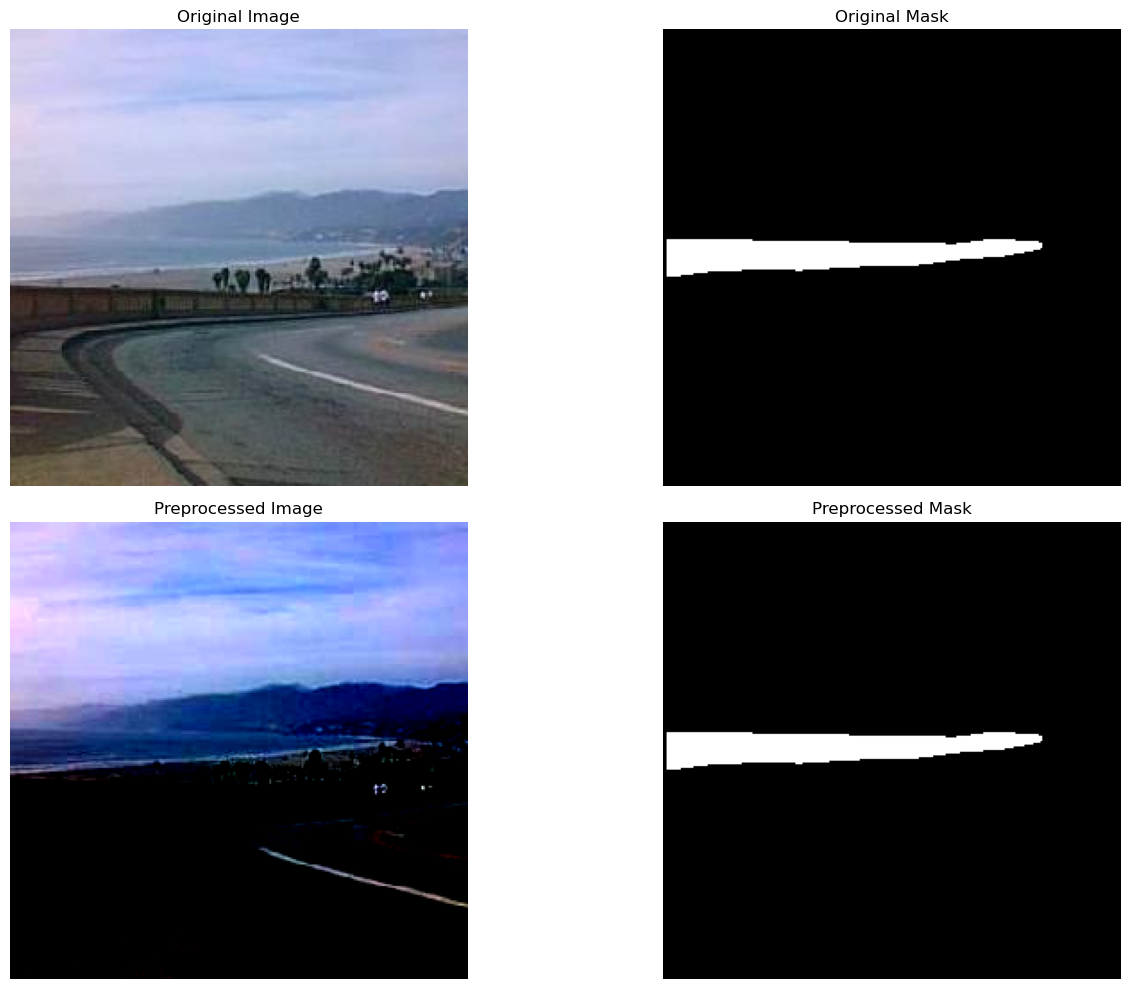

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8595966..1.0].


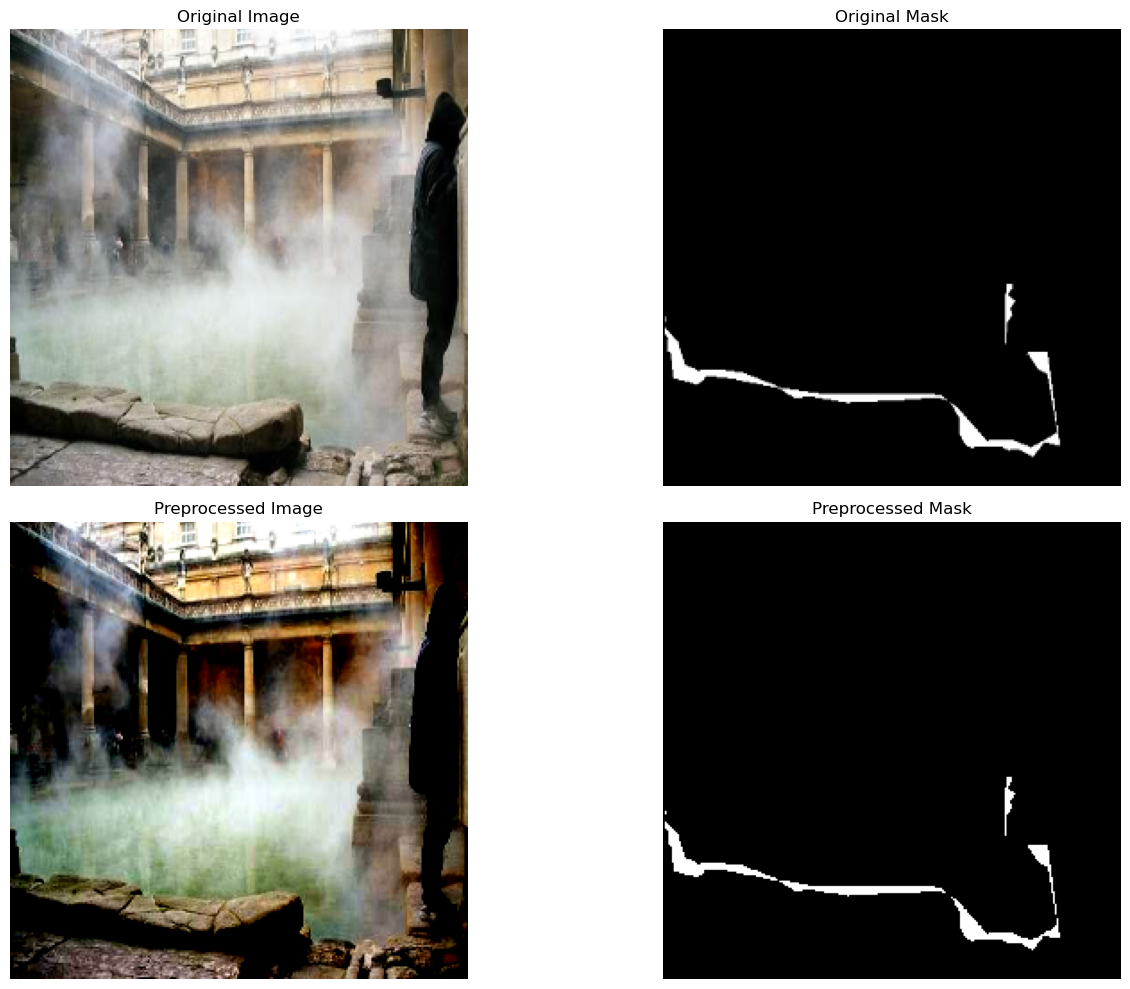

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.74785256].


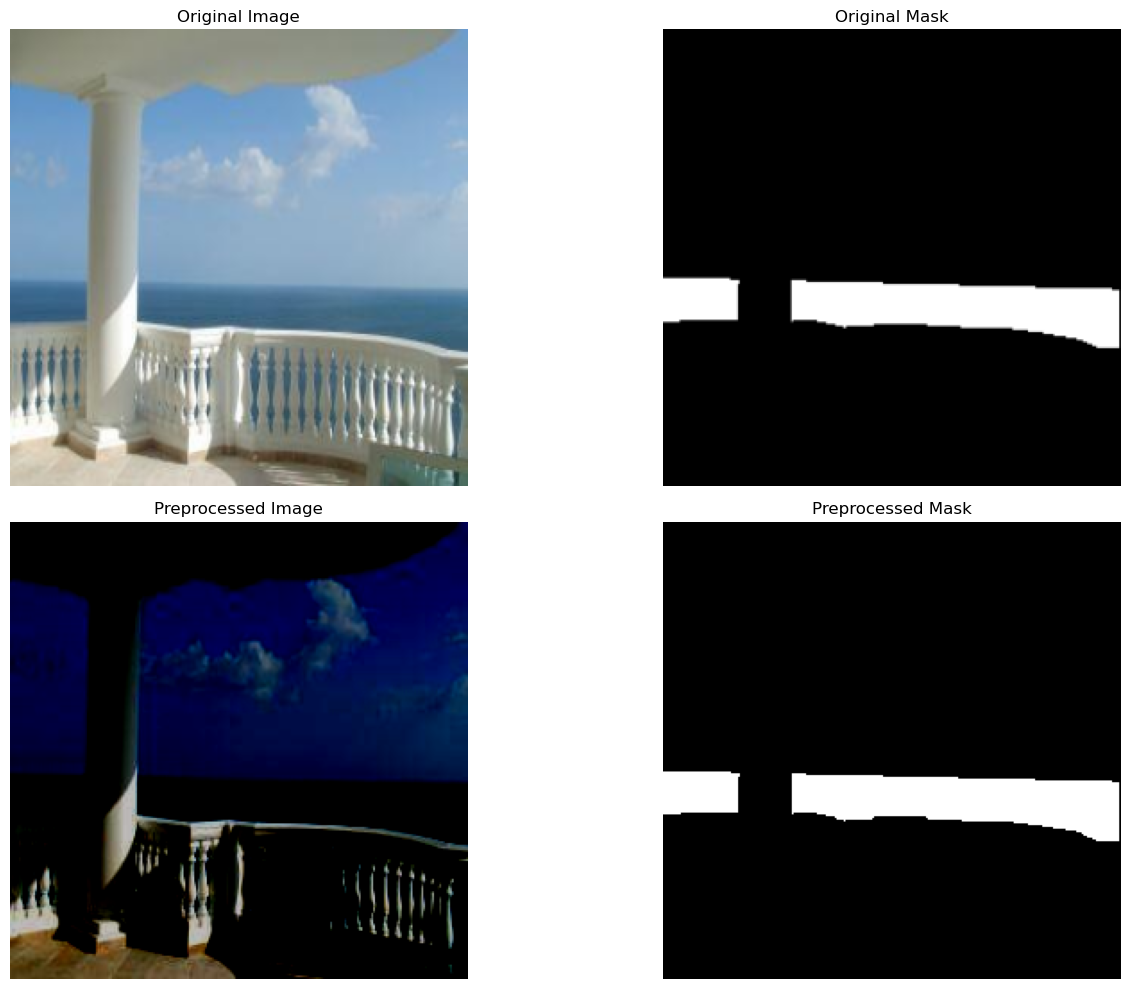

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.54847515..1.0].


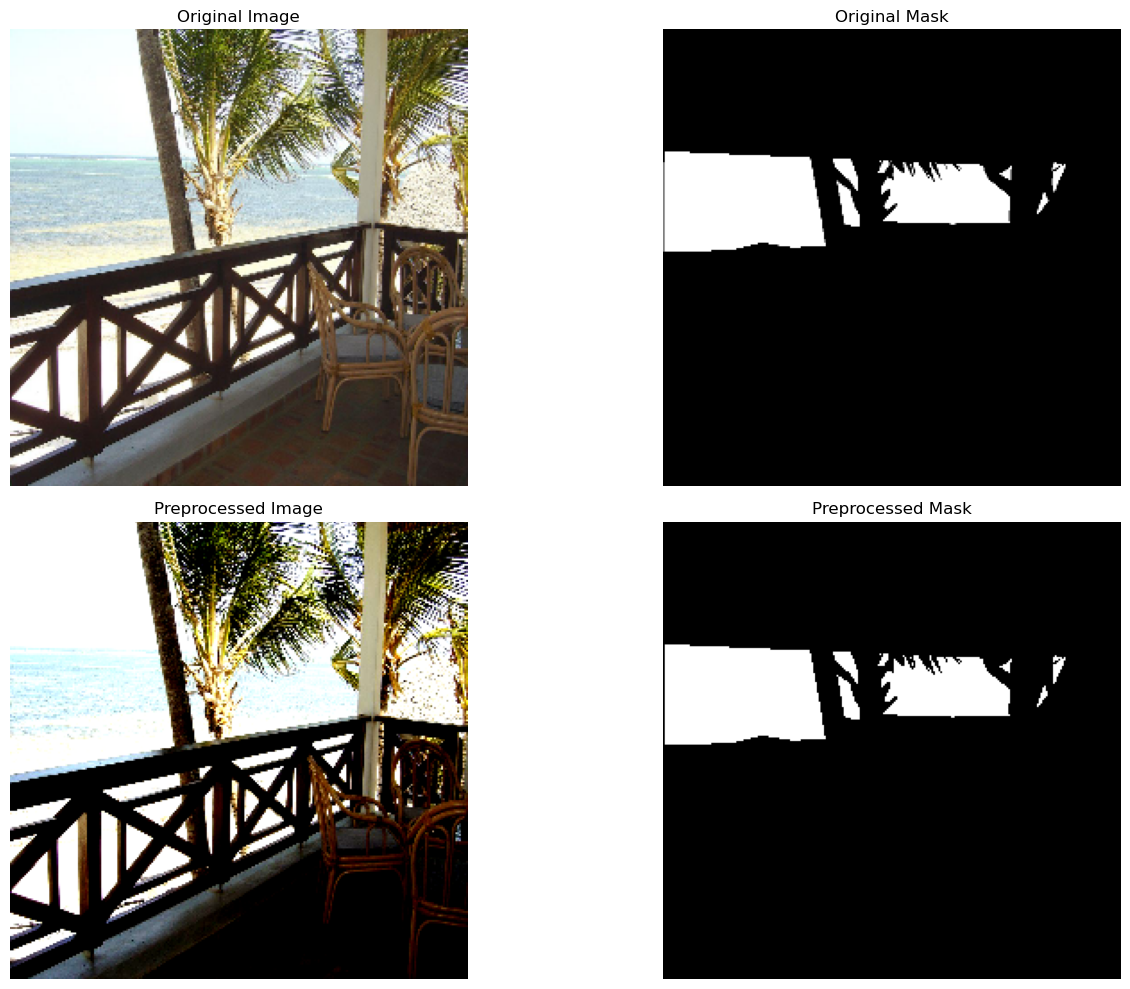

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.79226935].


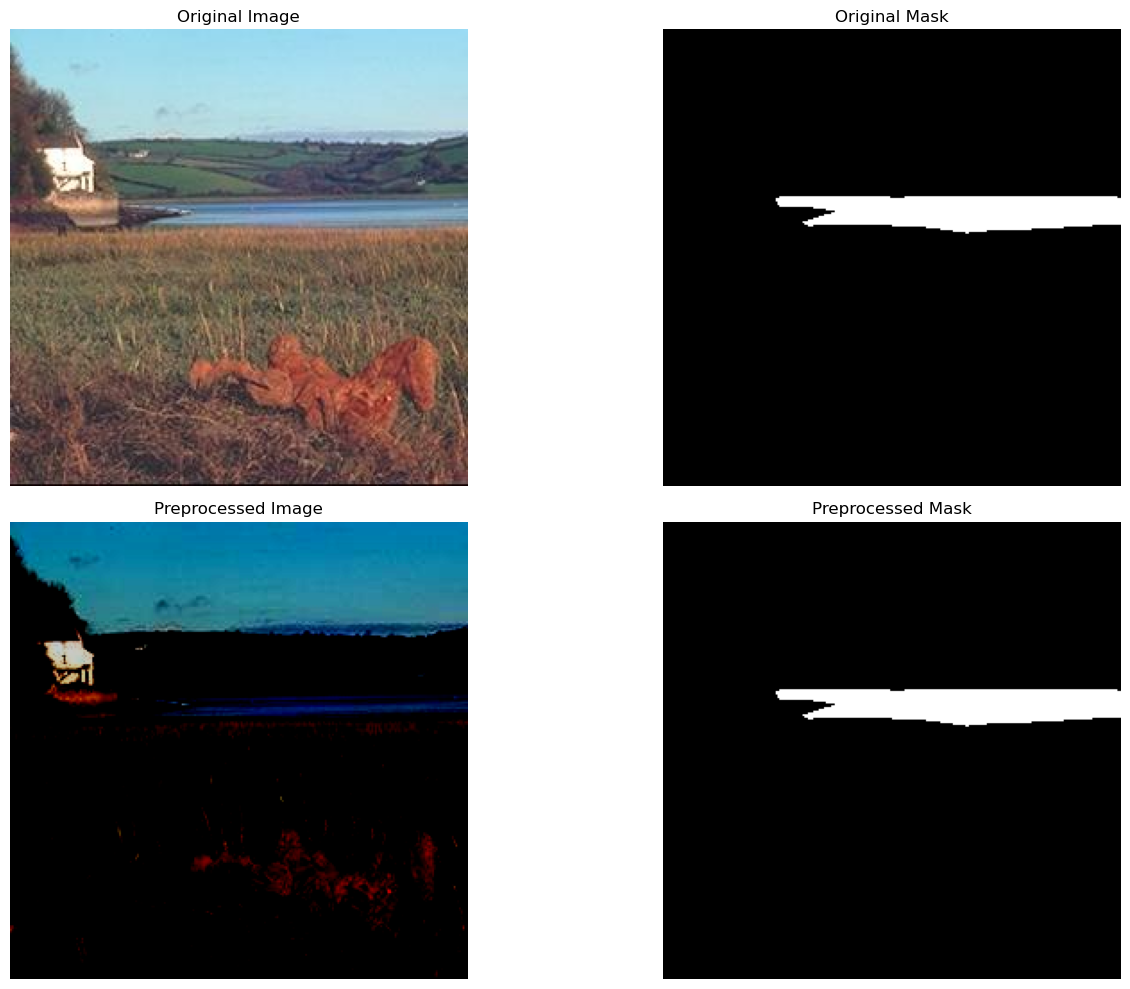

In [9]:
for i in range(5):
    id = randint(1000)
    image, mask = X_train[id], y_train[id]
    image_prep , mask_prep = X_train_prep[id], y_train_prep[id]
    plt.figure(figsize=(15,10))
    
    # Original Image
    plt.subplot(2,2,1)
    show_image(image, title="Original Image")
    
    # Original Mask
    plt.subplot(2,2,2)
    show_image(mask, title="Original Mask")
    
    # Preprocessed Image
    plt.subplot(2,2,3)
    show_image(image_prep, title="Preprocessed Image")
    
    # Preprocessed Mask
    plt.subplot(2,2,4)
    show_image(mask_prep, title="Preprocessed Mask")
    
    plt.tight_layout()
    plt.show()

# Creation Modele

In [10]:
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Input, MaxPooling2D
from tensorflow.keras.models import Model
import numpy as np

def create_unet():
    # Input
    inputs = Input(shape=(256, 256, 3))
    
    # Encoder Path (Contracting Path)
    # Block 1
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    # Block 2
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    # Block 3
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    # Block 4
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    
    # Bridge
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    
    # Decoder Path (Expanding Path)
    # Block 6
    up6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(conv5)
    concat6 = concatenate([up6, conv4])
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(concat6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    
    # Block 7
    up7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv6)
    concat7 = concatenate([up7, conv3])
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(concat7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)
    
    # Block 8
    up8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv7)
    concat8 = concatenate([up8, conv2])
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(concat8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(conv8)
    conv8 = BatchNormalization()(conv8)
    
    # Block 9
    up9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv8)
    concat9 = concatenate([up9, conv1])
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(concat9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)
    conv9 = BatchNormalization()(conv9)
    
    # Output - Changed from 1 to 3 channels to match your masks
    outputs = Conv2D(3, 1, activation='sigmoid')(conv9)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Create and compile the model
model_unet = create_unet()
model_unet.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.MeanIoU(num_classes=2)]
)
model_unet.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │      1,024 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │      2,048 │ conv2d_7[0][0]    │
│ (BatchNormalizatio… │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 16, 16,    │          0 │ batch_normalizat

 Total params: 31,043,651 (118.42 MB)

 Trainable params: 31,037,763 (118.40 MB)

 Non-trainable params: 5,888 (23.00 KB)

In [11]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.metrics import MeanIoU
# Callbacks
# Callbacks
# Callbacks for better training
callbacks = [
    ModelCheckpoint('best_fcn_model.keras', 
                    monitor='val_loss',
                    mode='min', 
                    save_best_only=True,
                    verbose=1),
    ReduceLROnPlateau(monitor='val_loss',
                      factor=0.1,
                      patience=5,
                      min_lr=1e-6,
                      verbose=1),
    EarlyStopping(monitor='val_loss',
                  patience=10,
                  restore_best_weights=True,
                  verbose=1)
]

# Train the model
history = model_unet.fit(
    X_train_prep, y_train_prep,
    validation_data=(X_val_prep, y_val_prep),
    batch_size=16,
    epochs=15,
    callbacks=callbacks
)

Epoch 1/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 15s/step - accuracy: 0.3204 - loss: 0.6635 - mean_io_u: 0.3858 
Epoch 1: val_loss improved from inf to 2.43383, saving model to best_fcn_model.keras
94/94 ━━━━━━━━━━━━━━━━━━━━ 1510s 16s/step - accuracy: 0.3200 - loss: 0.6628 - mean_io_u: 0.3858 - val_accuracy: 0.1109 - val_loss: 2.4338 - val_mean_io_u: 0.4149 - learning_rate: 0.0010
Epoch 2/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 15s/step - accuracy: 0.2082 - loss: 0.4794 - mean_io_u: 0.3880 
Epoch 2: val_loss improved from 2.43383 to 0.96667, saving model to best_fcn_model.keras
94/94 ━━━━━━━━━━━━━━━━━━━━ 1498s 16s/step - accuracy: 0.2080 - loss: 0.4792 - mean_io_u: 0.3879 - val_accuracy: 0.6112 - val_loss: 0.9667 - val_mean_io_u: 0.4021 - learning_rate: 0.0010
Epoch 3/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 15s/step - accuracy: 0.2098 - loss: 0.4112 - mean_io_u: 0.3862 
Epoch 3: val_loss improved from 0.96667 to 0.52479, saving model to best_fcn_model.keras
94/94 ━━━━━━━━━━━━━━━━━━━━ 1498s 16s/step - accura

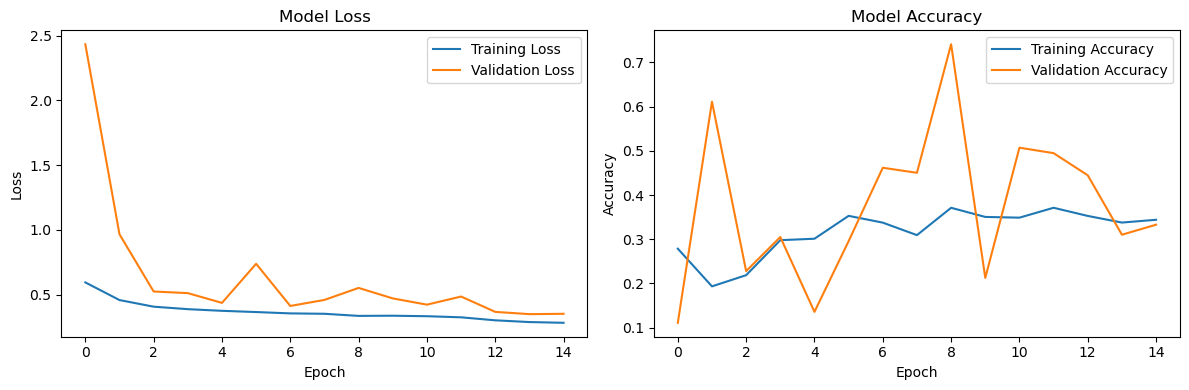

In [12]:
# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Modele (Deja fait juste code pour comprendre 10h d'execution) dans l'autre notebook

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 790ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9040947].


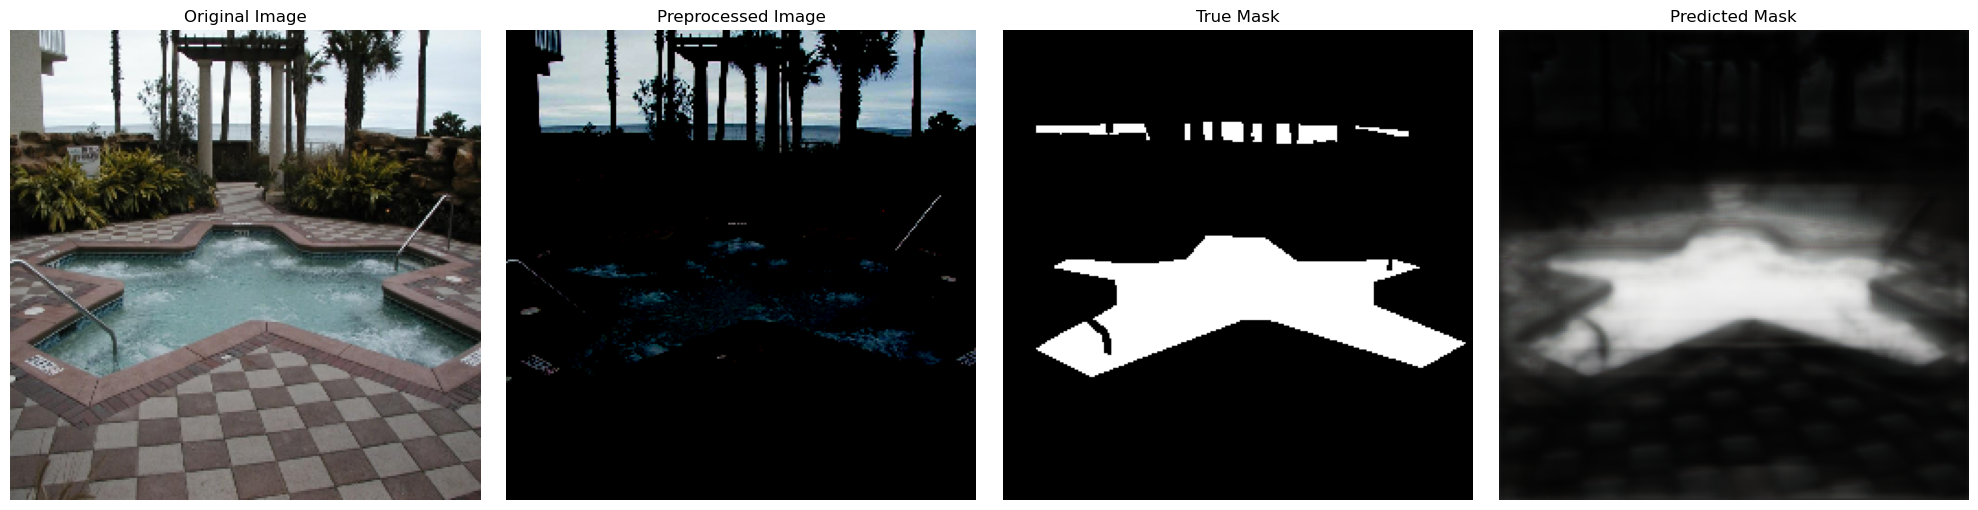

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.89422333..1.0].


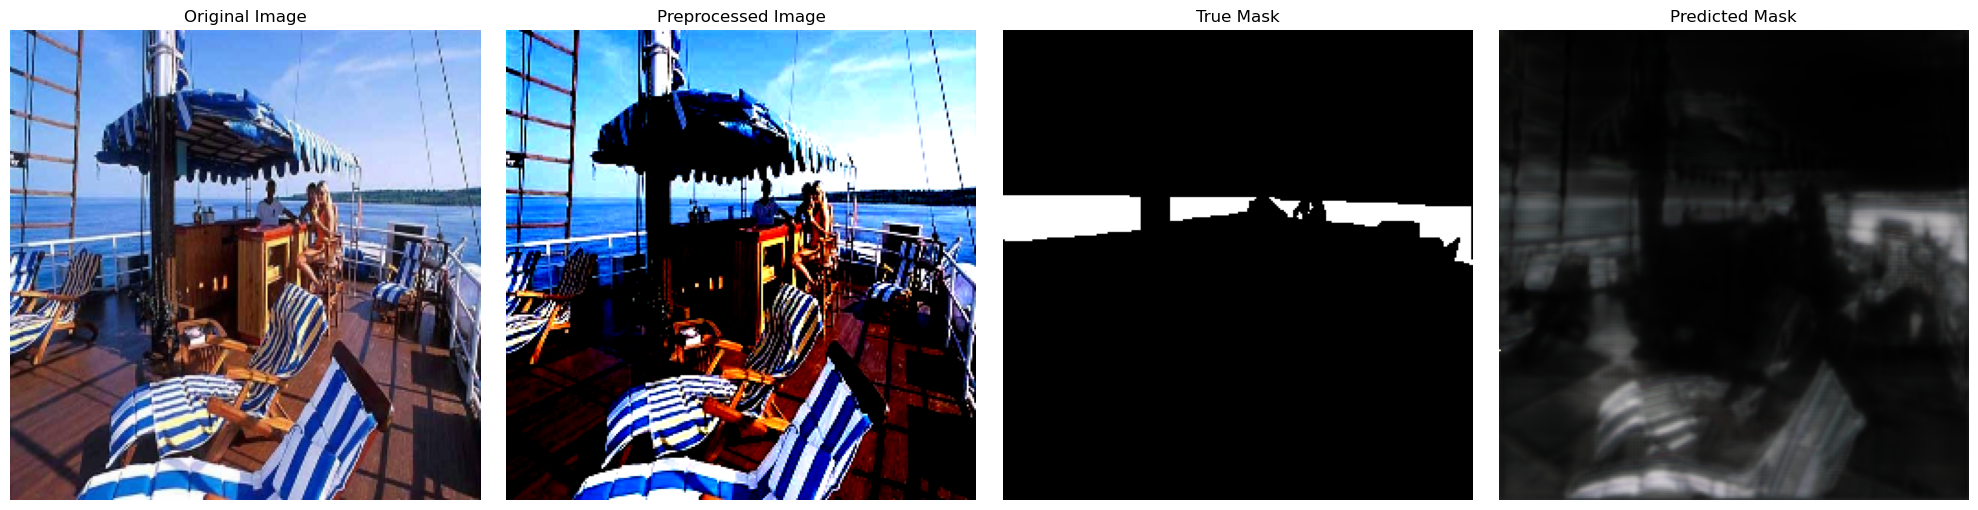

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7271168..1.0].


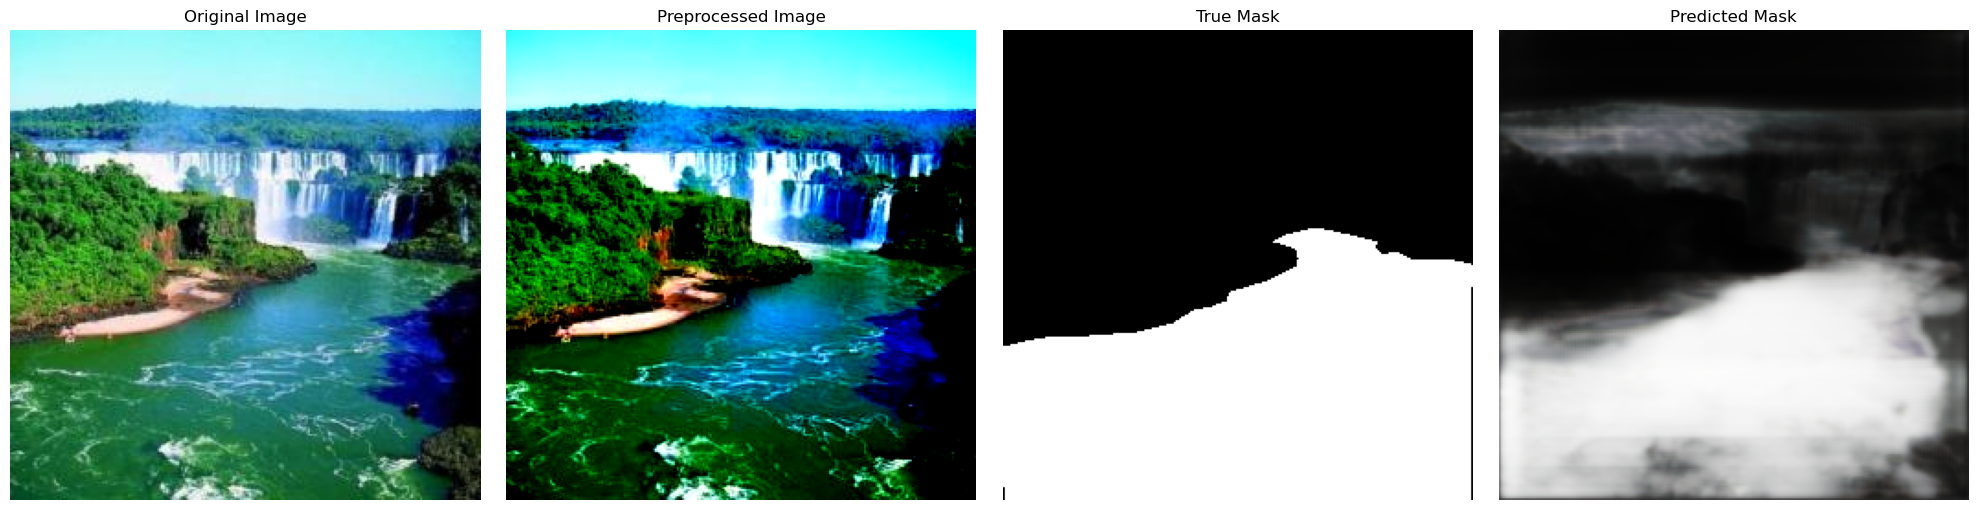

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.84047526..1.0].


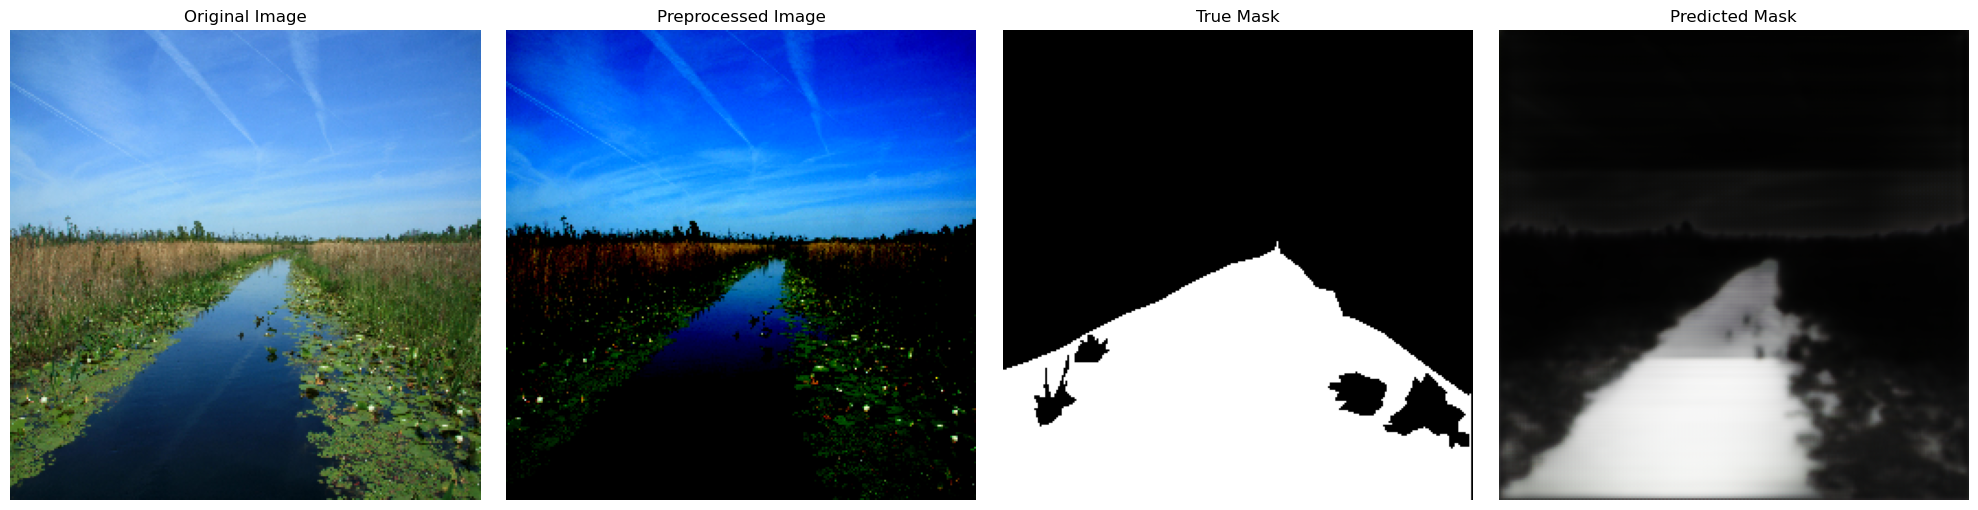

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 529ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.87189066..0.7520063].


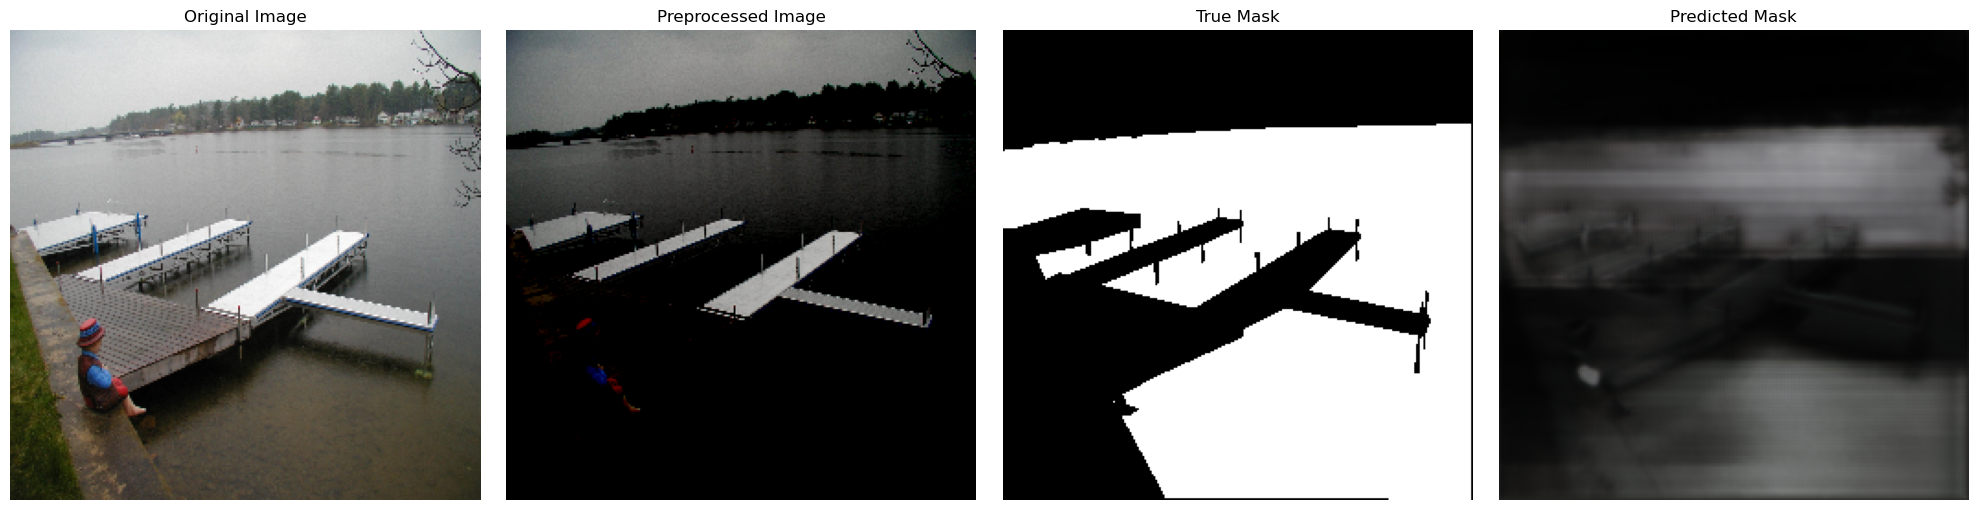

In [13]:
from tensorflow.keras.models import load_model

model = load_model('water_segmentation_unet_20241226.keras')


def show_predictions(model, X_orig, X_prep, y, num_samples=5):
    for i in range(num_samples):
        idx = np.random.randint(len(X_prep))
        
        # Get prediction
        pred = model.predict(X_prep[idx:idx+1])[0]
        
        plt.figure(figsize=(20, 5))
        
        # Original Image
        plt.subplot(1, 4, 1)
        show_image(X_orig[idx], title='Original Image')
        
        # Preprocessed Image
        plt.subplot(1, 4, 2)
        show_image(X_prep[idx], title='Preprocessed Image')
        
        # True Mask
        plt.subplot(1, 4, 3)
        show_image(y[idx], title='True Mask')
        
        # Predicted Mask
        plt.subplot(1, 4, 4)
        show_image(pred, title='Predicted Mask')
        
        plt.tight_layout()
        plt.show()

# Show predictions with both original and preprocessed images
show_predictions(model_unet, X_val, X_val_prep, y_val_prep)

In [14]:
model_unet.save('water_segmentation_unet_2.keras')
